# Strat:

## Class: COMP 4432
### Project: Assignment 2
#### Author: Michael Ghattas

In [97]:
# Load Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from IPython.display import display

# Load dataset
raw_data = load_diabetes(as_frame = True)
# display(raw_data)
# display(raw_data['frame'])
df = raw_data['frame']
# display(df.head(10))

#### Part One:

In [98]:
# Compute correlations
corr_matrix = df.corr()
target_corr = corr_matrix['target'].drop('target').sort_values(ascending = False)

In [99]:
# Display correlation matrix and top 4 features
display(target_corr.head(4))

bmi    0.586450
s5     0.565883
bp     0.441482
s4     0.430453
Name: target, dtype: float64

##### The four features most correlated with diabetes progression: (BMI: 0.5865 | S5: 0.5659 | BP: 0.4415 | S4: 0.4305)

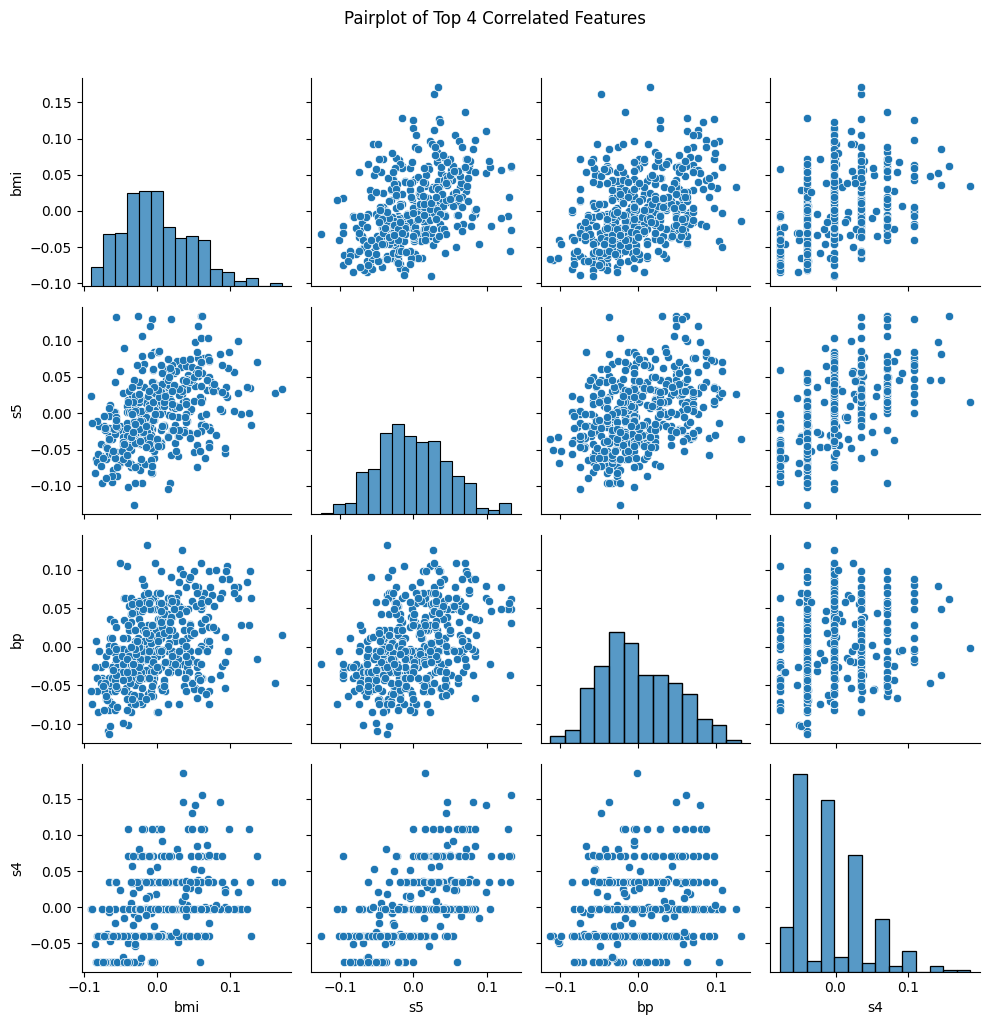

In [100]:
# Pairplot of top features
top_features = target_corr.head(4).index.tolist()
sns.pairplot(df, vars = top_features, hue = None)
plt.suptitle("Pairplot of Top 4 Correlated Features", y = 1.02)
plt.tight_layout()
plt.show()

In [101]:
# Split data
X = df.drop(columns = 'target')
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#### Part Two:

In [102]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state = 42),
    'Random Forest': RandomForestRegressor(random_state = 42)
}

In [103]:
# Evaluate models using 5-fold cross-validation
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error')
    rmse_scores = -scores
    print(f"{name} RMSE per fold: {rmse_scores}")
    cv_results[name] = {
        'mean_rmse': np.mean(rmse_scores),
        'std_rmse': np.std(rmse_scores)
    }

# Display cross-validation results
cv_df = pd.DataFrame(cv_results).T
cv_df = cv_df.rename(columns = {'mean_rmse': 'Mean RMSE', 'std_rmse': 'RMSE Std Dev'})
display(cv_df)

Linear Regression RMSE per fold: [52.53034465 58.93522481 52.08727478 56.50041896 59.80716652]
Decision Tree RMSE per fold: [74.57079064 80.9946964  80.65148462 79.58391797 85.39036413]
Random Forest RMSE per fold: [54.52038723 68.00166439 56.88656819 60.04114143 55.87601656]


,Mean RMSE,RMSE Std Dev
Linear Regression,55.972086,3.184478
Decision Tree,80.238251,3.459350
Random Forest,59.065156,4.824635


In [104]:
# Evaluate single feature (BMI) linear regression
X_train_bmi = X_train[['bmi']]
single_lr = LinearRegression()
single_scores = cross_val_score(single_lr, X_train_bmi, y_train, cv=5, scoring = 'neg_root_mean_squared_error')
single_rmse_scores = -single_scores
print("Single Feature Linear Regression (BMI)")
print("- RMSE per fold:", single_rmse_scores)
print("- Mean RMSE:", np.mean(single_rmse_scores))
print("- RMSE Std Dev:", np.std(single_rmse_scores))

Single Feature Linear Regression (BMI)
- RMSE per fold: [62.63654683 65.80955901 58.54772152 65.06090227 61.04527181]
- Mean RMSE: 62.62000028910842
- RMSE Std Dev: 2.6531032880526504


#### Part Three:

In [105]:
# Print default hyperparameters of DecisionTreeRegressor
default_dt = DecisionTreeRegressor(random_state = 42)
display(default_dt.get_params())

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [106]:
# Define parameter grid as a list of dictionaries for one GridSearchCV call
param_grid = [
    {'max_depth': list(range(1, 20))},
    {'min_samples_leaf': list(range(1, 51))}
]

# Instantiate the DecisionTreeRegressor
tree_model = DecisionTreeRegressor(random_state = 42)

# Create GridSearchCV with scoring as neg_root_mean_squared_error
tree_grid_search = GridSearchCV(
    estimator = tree_model,
    param_grid = param_grid,
    scoring = 'neg_root_mean_squared_error',
    cv = 5,
    n_jobs = -1,
    return_train_score = True
)

# Fit GridSearchCV
tree_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                        13, 14, 15, 16, 17, 18, 19]},
                         {'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14, 15, 16, 17, 18,
                                               19, 20, 21, 22, 23, 24, 25, 26,
                                               27, 28, 29, 30, ...]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [107]:
# Best result from the joint search
best_params = tree_grid_search.best_params_
best_score = -tree_grid_search.best_score_

print("Grid Search")
print(f"- Best Parameters: {best_params}")
print(f"- Best Cross-Validated RMSE: {best_score:.4f}")

Grid Search
- Best Parameters: {'max_depth': 2}
- Best Cross-Validated RMSE: 61.2638


- **Best Hyperparameter (from Grid Search)**: `max_depth = 2`
- **Best Cross-Validated RMSE**: 61.26
- This outperforms the Assignment 1 model using only the `bmi` feature (RMSE = 62.62).

In [108]:
# Summarize all hyperparameter combinations and RMSE
cv_results = tree_grid_search.cv_results_
results_summary = [
    {
        'params': params,
        'mean_test_rmse': -mean_score
    }
    for params, mean_score in zip(cv_results['params'], cv_results['mean_test_score'])
]
results_df = pd.DataFrame(results_summary)
results_df_sorted = results_df.sort_values(by = 'mean_test_rmse')
# Diplay top 10 combinations by RMSE
display(results_df_sorted.head(10))

,params,mean_test_rmse
1,{'max_depth': 2},61.263835
68,{'min_samples_leaf': 50},61.698972
67,{'min_samples_leaf': 49},62.267010
54,{'min_samples_leaf': 36},62.306453
66,{'min_samples_leaf': 48},62.306873
65,{'min_samples_leaf': 47},62.392300
64,{'min_samples_leaf': 46},62.392300
63,{'min_samples_leaf': 45},62.392300
61,{'min_samples_leaf': 43},62.506000
60,{'min_samples_leaf': 42},62.506000


#### Part Four:

In [109]:
# Print default parameters of Random Forest Regressor
rf_default = RandomForestRegressor(random_state = 42)
display(rf_default.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [110]:
# GridSearchCV with specified hyperparameters
param_grid_rf = {
    'n_estimators': [100, 200, 400, 500],
    'max_features': [2, 4, 6, 8, 10]
}

rf_grid = GridSearchCV(
    estimator = rf_default,
    param_grid = param_grid_rf,
    cv = 5,
    scoring = 'neg_root_mean_squared_error',
    return_train_score = True,
    n_jobs = -1
)

# Fit the grid search on full training set
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': [2, 4, 6, 8, 10],
                         'n_estimators': [100, 200, 400, 500]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [111]:
# Best Parameters and Best Score
print("Random Forest Grid Search")
print(f"- Best Parameters: {rf_grid.best_params_}")
print(f"- Best Cross-Validated RMSE: {-rf_grid.best_score_:.4f}")

Random Forest Grid Search
- Best Parameters: {'max_features': 4, 'n_estimators': 200}
- Best Cross-Validated RMSE: 57.5751


In [112]:
# Display all hyperparameter combinations and corresponding RMSE
rf_results_df = pd.DataFrame(rf_grid.cv_results_)
rf_results_df['mean_test_rmse'] = -rf_results_df['mean_test_score']
rf_rmse_summary = rf_results_df[['params', 'mean_test_rmse']].sort_values(by = 'mean_test_rmse')
display(rf_rmse_summary)

,params,mean_test_rmse
5,"{'max_features': 4, 'n_estimators': 200}",57.575070
4,"{'max_features': 4, 'n_estimators': 100}",57.654320
6,"{'max_features': 4, 'n_estimators': 400}",57.666695
7,"{'max_features': 4, 'n_estimators': 500}",57.699352
11,"{'max_features': 6, 'n_estimators': 500}",57.711836
9,"{'max_features': 6, 'n_estimators': 200}",57.733429
10,"{'max_features': 6, 'n_estimators': 400}",57.789093
8,"{'max_features': 6, 'n_estimators': 100}",57.945625
3,"{'max_features': 2, 'n_estimators': 500}",57.984527
2,"{'max_features': 2, 'n_estimators': 400}",58.049023


In [113]:
# Feature importances
best_rf = rf_grid.best_estimator_
importances = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending = False)

print("Random Forest Model")
display(importance_df)

Random Forest Model


,Feature,Importance
2,bmi,0.276136
8,s5,0.205969
3,bp,0.113577
9,s6,0.081539
6,s3,0.072997
5,s2,0.064550
4,s1,0.059292
0,age,0.059107
7,s4,0.055029
1,sex,0.011804


- The ranking aligns strongly with the Pearson correlation coefficients computed in Part 1c, where `bmi`, `s5`, and `bp` also exhibited the highest positive correlations with the target variable.
- While `s6` and `s3` had moderate to low correlations, the Random Forest model attributed relatively higher importance to them, suggesting their value in capturing non-linear patterns or interactions. 
- The low importance of `sex` is consistent with its weak correlation.

#### Part Five:

In [124]:
# Compare the average RMSE values
rmse_comparison = {
    "Linear Regression (All Features)": cv_df.loc["Linear Regression", "Mean RMSE"],
    "Linear Regression (Single Feature - BMI)": np.mean(single_rmse_scores),
    "Decision Tree (Baseline)": cv_df.loc["Decision Tree", "Mean RMSE"],
    "Decision Tree (Tuned)": best_score,
    "Random Forest (Baseline)": cv_df.loc["Random Forest", "Mean RMSE"],
    "Random Forest (Tuned)": -rf_grid.best_score_
}

# Convert to DataFrame, sort, and diplay results
rmse_comparison_df = pd.DataFrame(
    rmse_comparison.items(),
    columns=["Model", "Average RMSE (Train CV)"]
).sort_values(by = "Average RMSE (Train CV)").reset_index(drop = True)

print("RMSE Comparison Across Models:")
display(rmse_comparison_df)

RMSE Comparison Across Models:


,Model,Average RMSE (Train CV)
0,Linear Regression (All Features),55.972086
1,Random Forest (Tuned),57.575070
2,Random Forest (Baseline),59.065156
3,Decision Tree (Tuned),61.263835
4,Linear Regression (Single Feature - BMI),62.620000
5,Decision Tree (Baseline),80.238251


The **Linear Regression (All Features)** model is selected as the **Champion Model** as it has the **lowest cross-validated RMSE** of **55.97**, and it was trained and evaluated using **5-fold cross-validation** on the training data.

In [126]:
# Fit the champion model (Linear Regression) on the entire training set
champion_model = LinearRegression()
champion_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = champion_model.predict(X_test)

# Calculate RMSE on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(mse_test)

# Print the test set RMSE
print(f"Test Set RMSE (Champion Model): {test_rmse:.4f}")

Test Set RMSE (Champion Model): 53.8534


- The **test RMSE of 53.85** is slightly lower than the **training RMSE of 55.97**. This suggests that the model generalizes well to unseen data.
- There is no evidence of overfitting, and the model has maintained its predictive performance across both training and test sets.
- The Linear Regression model trained on all features is a statistically robust and practically effective** choice for predicting diabetes progression based on the given dataset.

## Note:
### This work has been assisted by GenAI models for the purpose of code debugging, validation, and enhancment. All GenAI assisted output was evaluated, verified, and adopted by author as needed to maintain academic ethical standards of conduct.

# End.